In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

################################# 数据 读取-处理 开始#################################
sheet = pd.read_excel('data_input_auto/中国汽油实际消费量.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['中国汽油实际消费量'].last_valid_index()


sheet = sheet.rename(columns={'全球经济惊喜指数': '全球经济惊喜指数（同花顺）'})

sheet.columns  

Index(['中国汽油实际消费量', '百度全国迁徙规模指数/7DMA', 'WESTPAC中国经济惊喜指数同比',
       '中国十年期国债收益率/日频Non-Trend/F0.2', '最高零售价：汽油（标准品）：山东（日度）',
       '上证新能源指数收盘价/上证综合指数20日环比', '汽油情绪指数', '比亚迪股价/沪深300 20日环比',
       '92#汽油价差（华东-山东）', '山东汽油裂解差', 'DR007利率/5DMA', '汽油：社会库存：中国（周）：大样本4周环差',
       '全球经济惊喜指数（同花顺）'],
      dtype='object')

In [4]:

################################# 处理数据 让他们更适合 用来预测之后一个月的数据  #################################

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
# 所有数据截止到target_end
sheet = sheet[sheet.index <= target_end]


In [5]:
file_path1 = os.path.expanduser("eta/山东汽油裂解差_合并数据.xlsx") 
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()

sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.tail()

,Date,预测值
4,2025-05-26,934.6385
3,2025-05-27,938.0806
2,2025-05-28,939.7545
1,2025-05-29,832.5187
0,2025-05-30,844.6515


In [6]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['山东汽油裂解差'] = sheet_daily['山东汽油裂解差'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])


# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')

In [7]:


################################# 处理缺失值 #################################
fill_methods = {
    '百度全国迁徙规模指数/7DMA':'interpolate', 
    'WESTPAC中国经济惊喜指数同比':'interpolate',
    '中国十年期国债收益率/日频Non-Trend/F0.2':'interpolate', 
    '最高零售价：汽油（标准品）：山东（日度）':'interpolate',
    '上证新能源指数收盘价/上证综合指数20日环比':'interpolate',
    '汽油情绪指数':'interpolate',
    '比亚迪股价/沪深300 20日环比':'interpolate',
    '92#汽油价差（华东-山东）':'interpolate', 
    '山东汽油裂解差':'interpolate', 
    'DR007利率/5DMA' :'interpolate',
    '汽油：社会库存：中国（周）：大样本4周环差':'interpolate',
    '全球经济惊喜指数（同花顺）':'interpolate',                                                                                        
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, '中国柴油实际消费量Non-Trend/F0.2'] = sheet.loc[:last_day, '中国柴油实际消费量Non-Trend/F0.2'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['WESTPAC中国经济惊喜指数同比_提前35天'] = sheet['WESTPAC中国经济惊喜指数同比'].shift(35)
sheet['中国十年期国债收益率/日频Non-Trend/F0.2_提前65天'] = sheet['中国十年期国债收益率/日频Non-Trend/F0.2'].shift(65)
sheet['最高零售价：汽油（标准品）：山东（日度）_提前50天'] = sheet['最高零售价：汽油（标准品）：山东（日度）'].shift(50)
sheet['上证新能源指数收盘价/上证综合指数20日环比_提前20天'] = sheet['上证新能源指数收盘价/上证综合指数20日环比'].shift(20)
sheet['汽油情绪指数_提前20天'] = sheet['汽油情绪指数'].shift(20)
sheet['比亚迪股价/沪深300 20日环比_提前20天'] = sheet['比亚迪股价/沪深300 20日环比'].shift(20)
sheet['92#汽油价差（华东-山东）_提前50天'] = sheet['92#汽油价差（华东-山东）'].shift(50)
sheet['DR007利率/5DMA_提前20天'] = sheet['DR007利率/5DMA'].shift(20)
sheet['汽油：社会库存：中国（周）：大样本4周环差_提前30天'] = sheet['汽油：社会库存：中国（周）：大样本4周环差'].shift(30)                                                                                    
sheet['全球经济惊喜指数（同花顺）_提前70天'] = sheet['全球经济惊喜指数（同花顺）'].shift(70)


sheet['最高零售价：汽油（标准品）：山东（日度）_提前50天_逆序'] = reverse_column(sheet, '最高零售价：汽油（标准品）：山东（日度）_提前50天')
sheet['上证新能源指数收盘价/上证综合指数20日环比_提前20天_逆序'] = reverse_column(sheet, '上证新能源指数收盘价/上证综合指数20日环比_提前20天')
sheet['比亚迪股价/沪深300 20日环比_提前20天_逆序'] = reverse_column(sheet, '比亚迪股价/沪深300 20日环比_提前20天')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2021-03-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['中国汽油实际消费量'].notna())
]

################################# 数据 读取-处理 结束 #################################

In [8]:
sheet_daily.columns

Index(['Date', '中国汽油实际消费量', '百度全国迁徙规模指数/7DMA', 'WESTPAC中国经济惊喜指数同比',
       '中国十年期国债收益率/日频Non-Trend/F0.2', '最高零售价：汽油（标准品）：山东（日度）',
       '上证新能源指数收盘价/上证综合指数20日环比', '汽油情绪指数', '比亚迪股价/沪深300 20日环比',
       '92#汽油价差（华东-山东）', '山东汽油裂解差', 'DR007利率/5DMA', '汽油：社会库存：中国（周）：大样本4周环差',
       '全球经济惊喜指数（同花顺）', 'WESTPAC中国经济惊喜指数同比_提前35天',
       '中国十年期国债收益率/日频Non-Trend/F0.2_提前65天', '最高零售价：汽油（标准品）：山东（日度）_提前50天',
       '上证新能源指数收盘价/上证综合指数20日环比_提前20天', '汽油情绪指数_提前20天',
       '比亚迪股价/沪深300 20日环比_提前20天', '92#汽油价差（华东-山东）_提前50天', 'DR007利率/5DMA_提前20天',
       '汽油：社会库存：中国（周）：大样本4周环差_提前30天', '全球经济惊喜指数（同花顺）_提前70天',
       '最高零售价：汽油（标准品）：山东（日度）_提前50天_逆序', '上证新能源指数收盘价/上证综合指数20日环比_提前20天_逆序',
       '比亚迪股价/沪深300 20日环比_提前20天_逆序'],
      dtype='object')

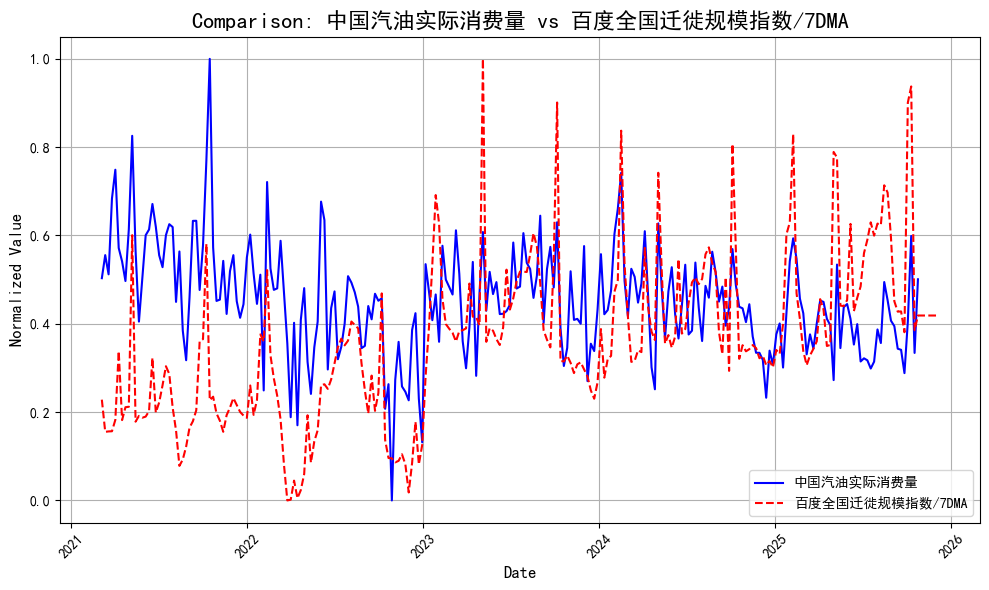

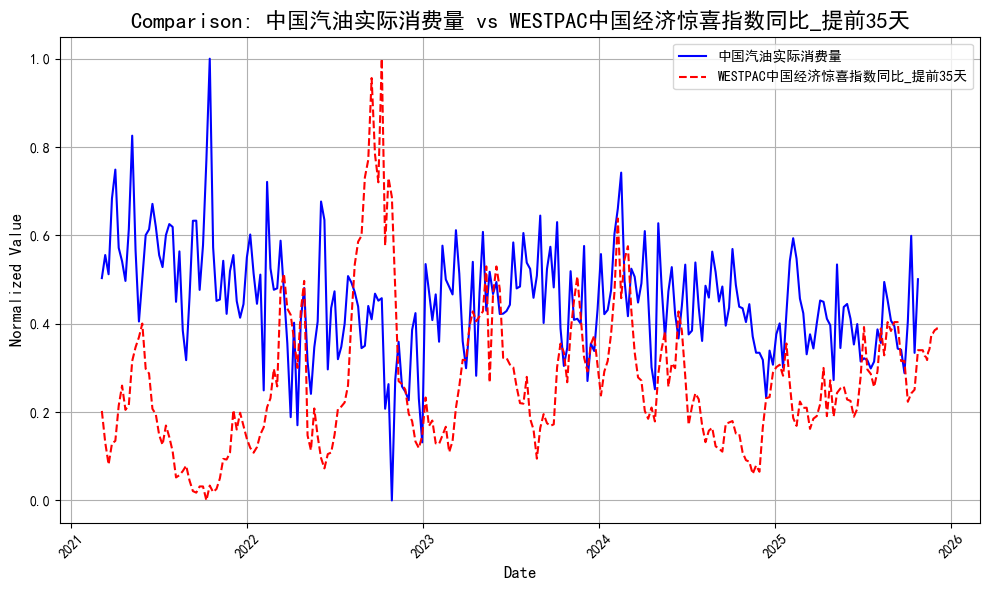

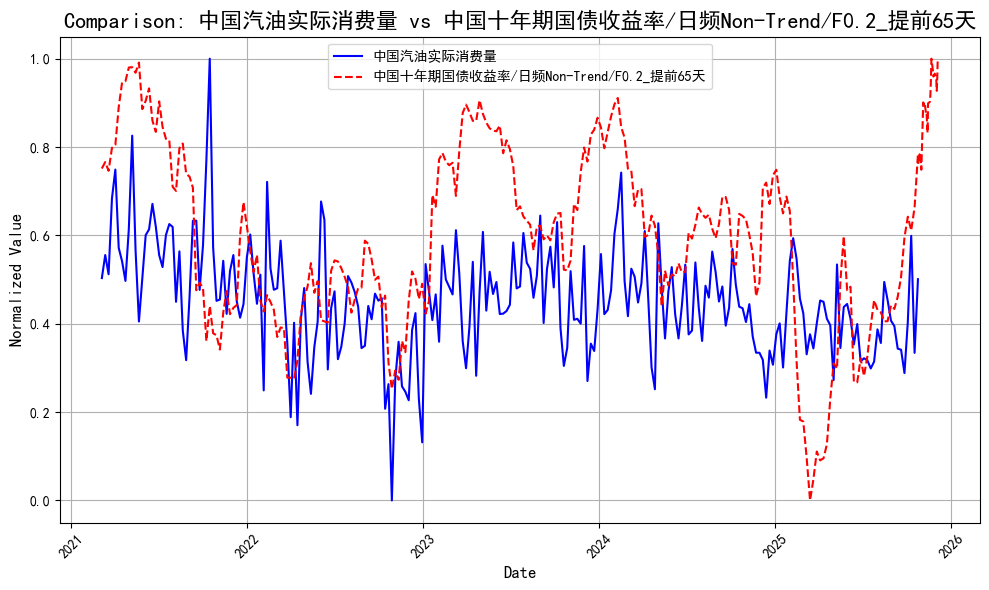

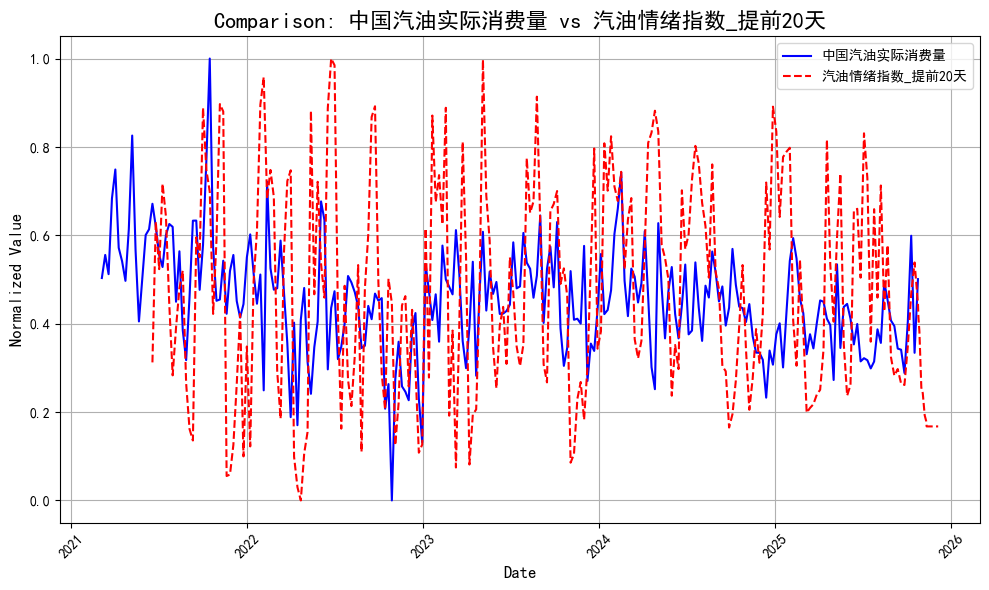

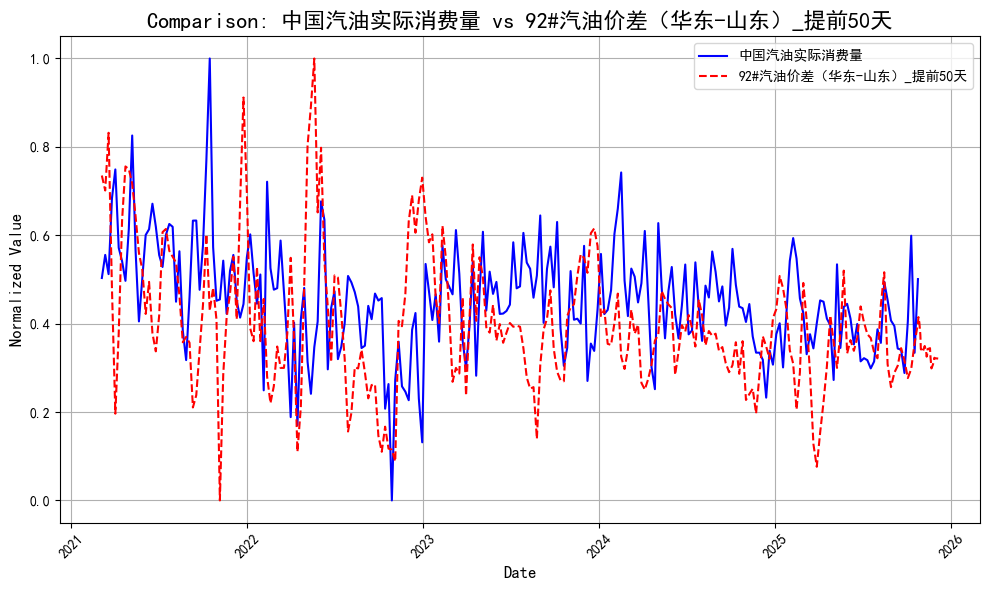

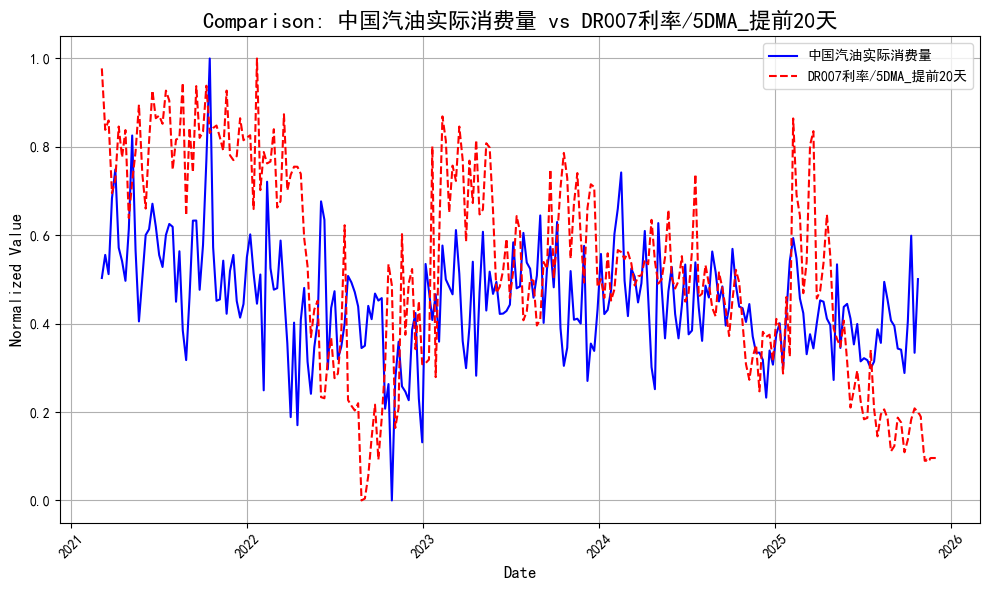

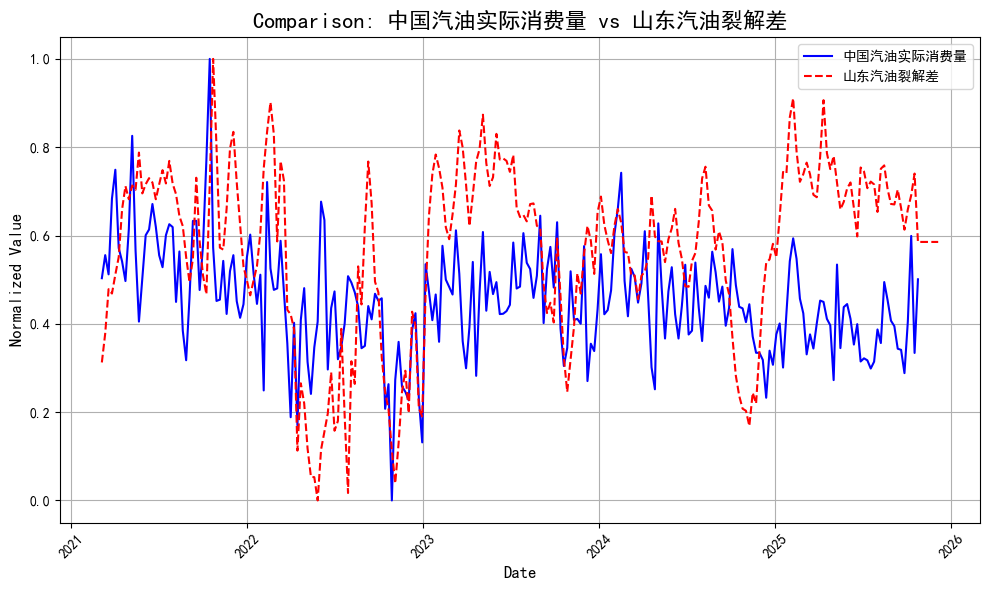

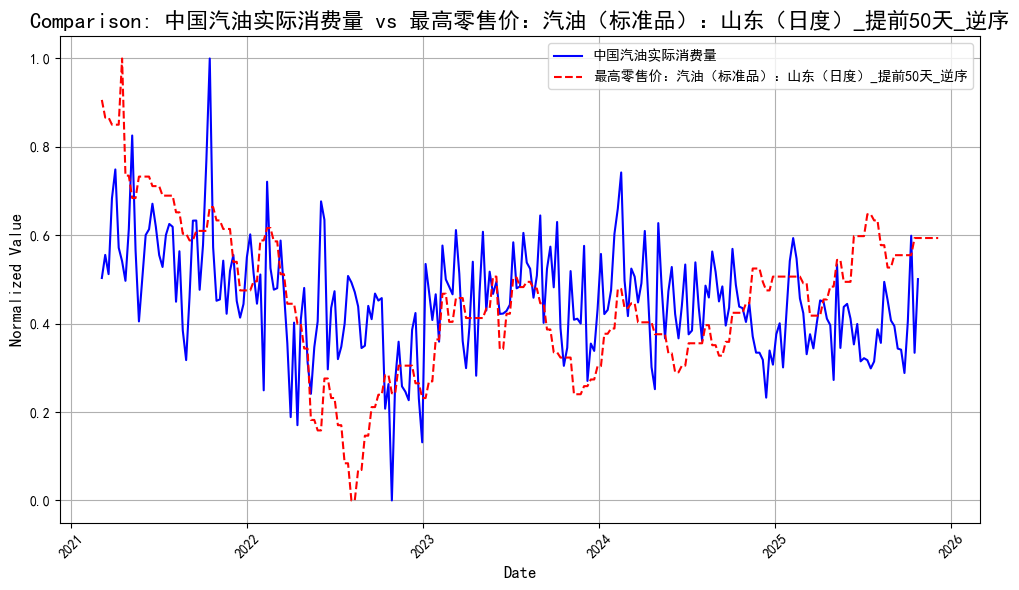

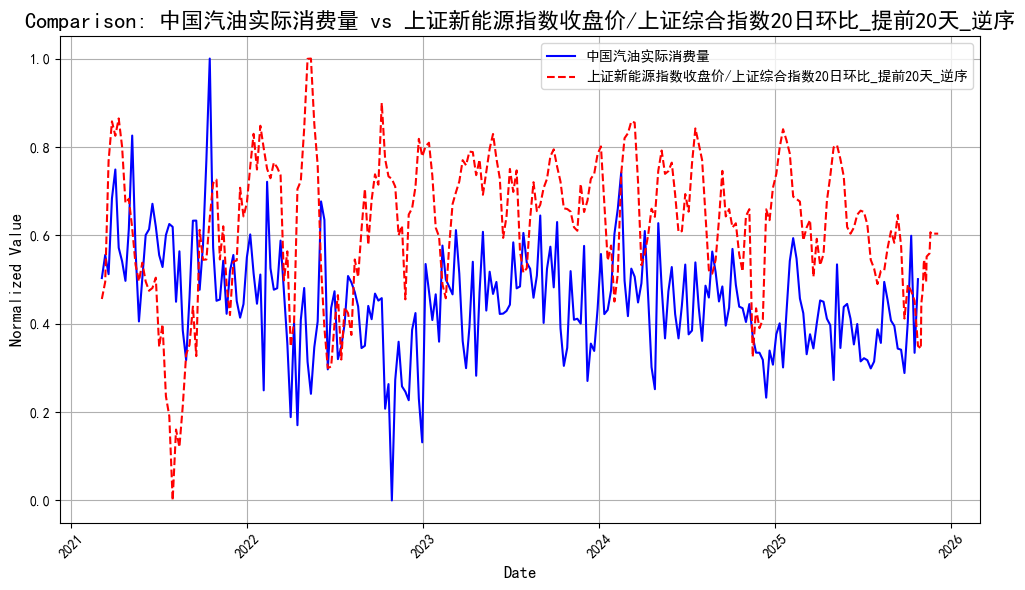

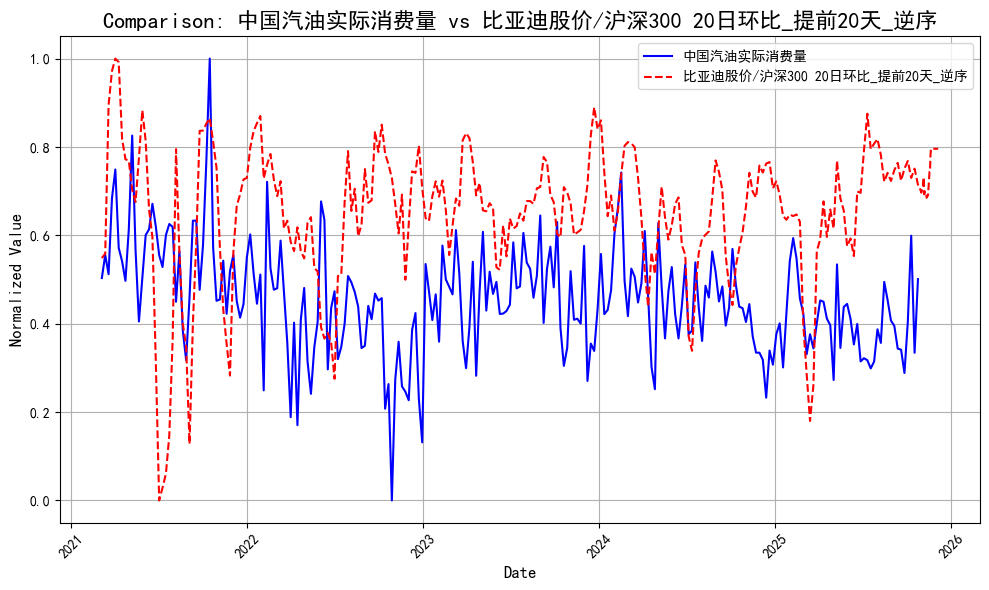

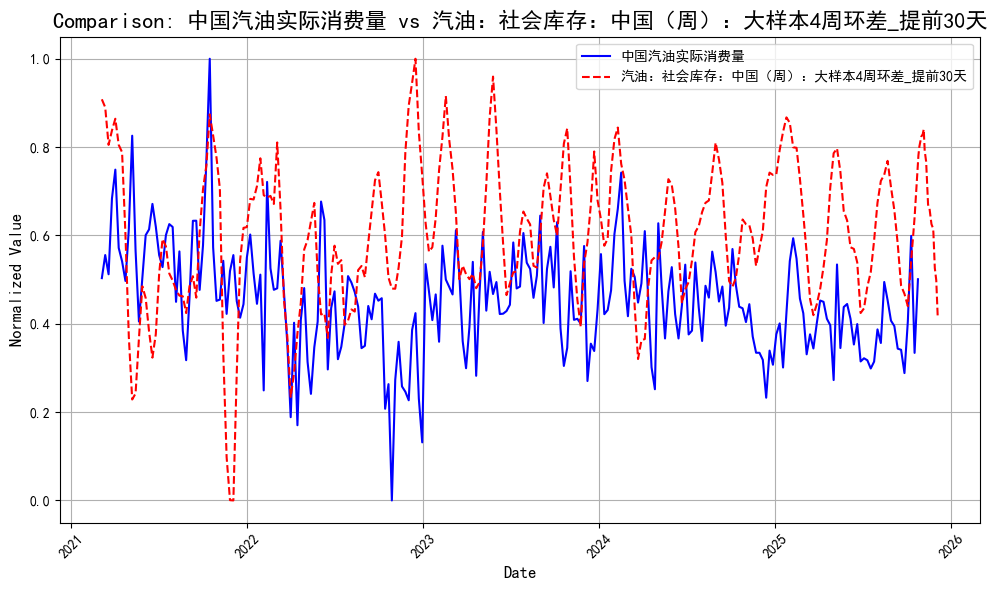

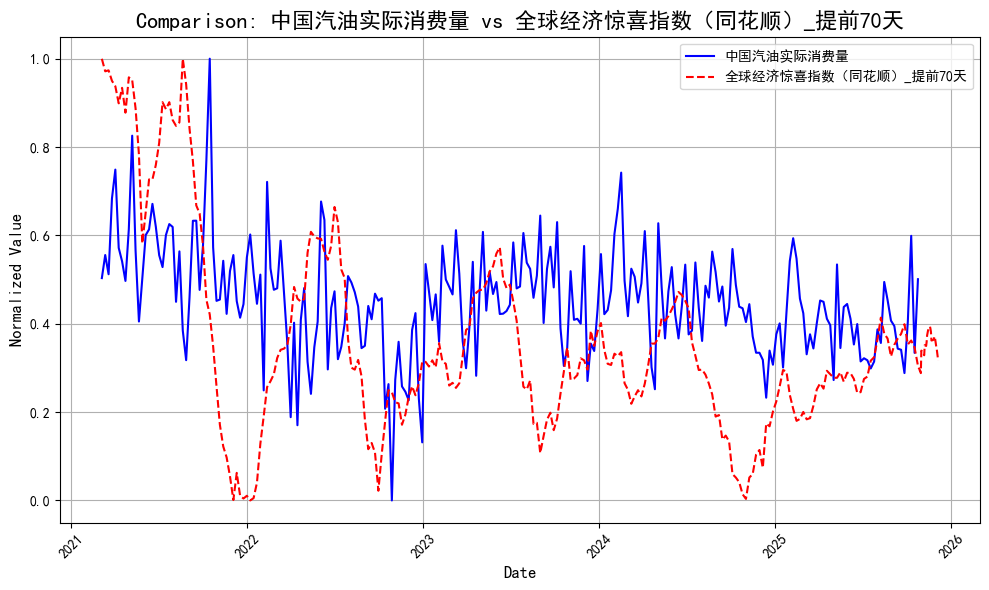

In [9]:
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='中国汽油实际消费量', 
    compare_cols=[
        '百度全国迁徙规模指数/7DMA',
        'WESTPAC中国经济惊喜指数同比_提前35天',
        '中国十年期国债收益率/日频Non-Trend/F0.2_提前65天',  
        '汽油情绪指数_提前20天',
        '92#汽油价差（华东-山东）_提前50天', 
        'DR007利率/5DMA_提前20天',
        '山东汽油裂解差',
       '最高零售价：汽油（标准品）：山东（日度）_提前50天_逆序',
        '上证新能源指数收盘价/上证综合指数20日环比_提前20天_逆序',
       '比亚迪股价/沪深300 20日环比_提前20天_逆序',
       '汽油：社会库存：中国（周）：大样本4周环差_提前30天',
       '全球经济惊喜指数（同花顺）_提前70天'
       ]
)

In [10]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 10
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '百度全国迁徙规模指数/7DMA',
        'WESTPAC中国经济惊喜指数同比_提前35天',
        '中国十年期国债收益率/日频Non-Trend/F0.2_提前65天',  
        '汽油情绪指数_提前20天',
        '92#汽油价差（华东-山东）_提前50天', 
        'DR007利率/5DMA_提前20天',
        '山东汽油裂解差',
       '最高零售价：汽油（标准品）：山东（日度）_提前50天_逆序',
        '上证新能源指数收盘价/上证综合指数20日环比_提前20天_逆序',
       '比亚迪股价/沪深300 20日环比_提前20天_逆序',
       '汽油：社会库存：中国（周）：大样本4周环差_提前30天',
       '全球经济惊喜指数（同花顺）_提前70天'
]

predict_column = '中国汽油实际消费量'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 较小的学习率
    'max_depth': 7,  # 控制树的深度防止过拟合
    'min_child_weight': 1,  # 控制过拟合
    'subsample': 0.8,  # 随机采样防止过拟合
    'colsample_bytree': 0.8,  # 特征随机采样
    'gamma': 0.5,  # 控制分裂
    'reg_alpha': 1,  # L1正则化
    'reg_lambda': 1,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
    'max_delta_step': 5,
    'tree_method': 'auto'
}

num_boost_round = 3000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=100 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:27.51435	train-rmse:31.74936


[100]	eval-rmse:25.50698	train-rmse:28.97041


[200]	eval-rmse:23.90009	train-rmse:26.33566


[300]	eval-rmse:22.75593	train-rmse:23.82309


[400]	eval-rmse:21.77163	train-rmse:21.41688

[500]	eval-rmse:21.15248	train-rmse:19.13255

[600]	eval-rmse:20.62572	train-rmse:17.00627

[700]	eval-rmse:20.32162	train-rmse:15.07633


[800]	eval-rmse:19.94181	train-rmse:13.36163

[900]	eval-rmse:19.67207	train-rmse:11.84782

[1000]	eval-rmse:19.40216	train-rmse:10.56722


[1100]	eval-rmse:19.12319	train-rmse:9.43186

[1200]	eval-rmse:19.07052	train-rmse:8.47935


[1300]	eval-rmse:19.06868	train-rmse:7.66389

[1400]	eval-rmse:19.07499	train-rmse:6.91021

[1500]	eval-rmse:19.19818	train-rmse:6.23879


[1600]	eval-rmse:19.30051	train-rmse:5.63809


[1700]	eval-rmse:19.27394	train-rmse:5.08575

[1800]	eval-rmse:19.31315	train-rmse:4.62759

[1900]	eval-rmse:19.29416	train-rmse:4.22034


[2000]	eval-rmse:19.29904	train-rmse:3.87047

[2100]	eval-rmse:19.26856	train-rmse:3.54398

[2200]	eval-rmse:19.27947	train-rmse:3.24006

[2300]	eval-rmse:19.27715	train-rmse:2.96585

[2400]	eval-rmse:19.28427	train-rmse:2.70587

[2500]	eval-rmse:19.30318	train-rmse:2.48122

[2600]	eval-rmse:19.31380	train-rmse:2.25689

[2700]	eval-rmse:19.33752	train-rmse:2.04012

[2800]	eval-rmse:19.34468	train-rmse:1.85428


[2900]	eval-rmse:19.36021	train-rmse:1.67053


[2999]	eval-rmse:19.38559	train-rmse:1.50824


训练集 MSE (DMatrix): 5.324, 训练集 R² (DMatrix): 0.9956


测试集 MSE (DMatrix): 375.8008, 测试集 R² (DMatrix): 0.3621


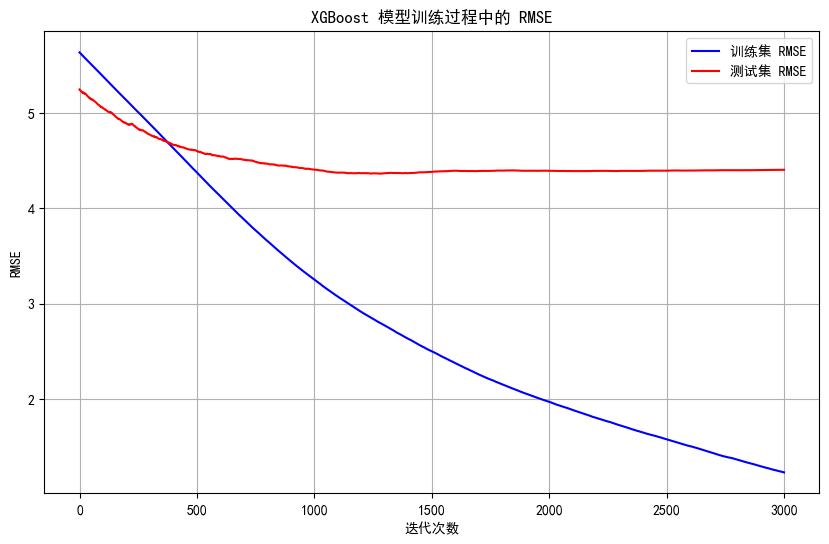

In [11]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=200
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:31.57938


[200]	train-rmse:26.14227


[400]	train-rmse:21.23102


[600]	train-rmse:16.84604

[800]	train-rmse:13.26609


[1000]	train-rmse:10.51465


[1200]	train-rmse:8.44876


[1400]	train-rmse:6.87821


[1600]	train-rmse:5.62074


[1800]	train-rmse:4.62650


[2000]	train-rmse:3.86745


[2200]	train-rmse:3.23278


[2400]	train-rmse:2.69353


[2600]	train-rmse:2.24937

[2800]	train-rmse:1.84986

[2999]	train-rmse:1.51004

全部数据 MSE: 5.3167, 全部数据 R²: 0.9955

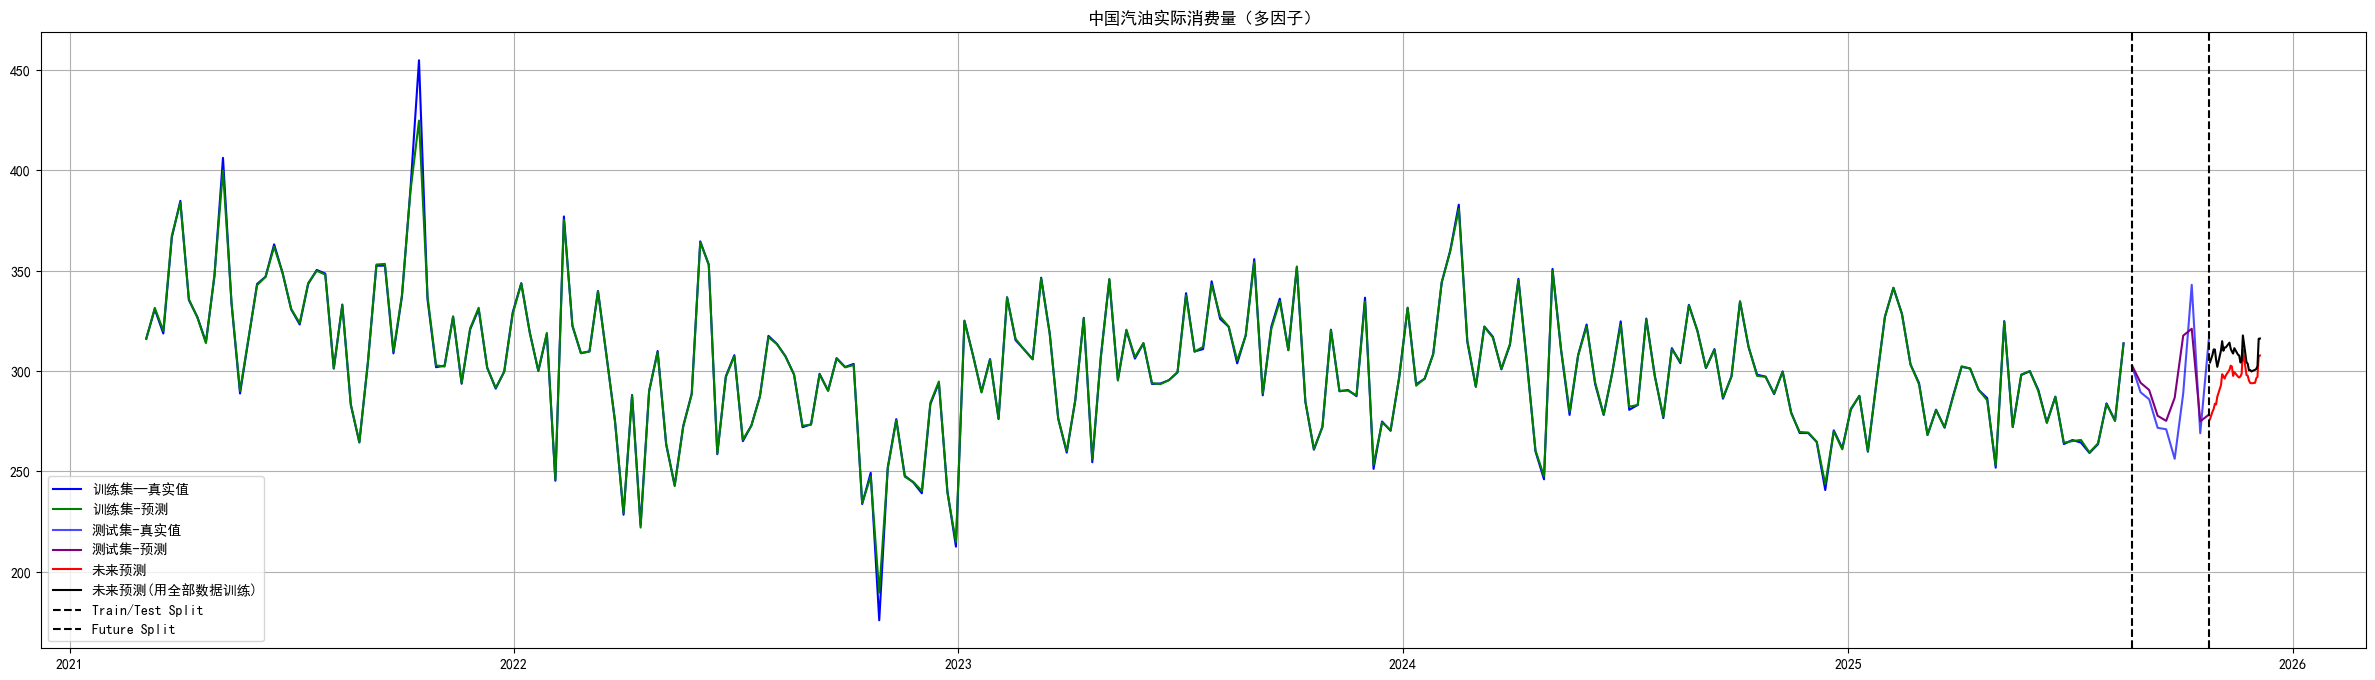

In [13]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('中国汽油实际消费量（多因子）')
plt.legend()
plt.grid(True)
plt.show()


---

In [14]:
################################# 训练预测数据 excel格式输出  #################################

############ 日度 数据 ############
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})

historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})

merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/中国汽油实际消费量(多因子)_合并数据.xlsx', index=False,float_format='%.4f')

############ 月度 数据 ############
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
test_pred_2024 = test_data[['Date', '预测值']].copy()
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly['真实值'] = merged_df_monthly['真实值'].round(1)
merged_df_monthly['预测值'] = merged_df_monthly['预测值'].round(1)
merged_df_monthly.to_excel('eta/中国汽油实际消费量(多因子)_月度数据.xlsx', index=False,float_format= '%.4f')

---

In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中国汽油实际消费量(多因子)"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中国汽油实际消费量(多因子)"
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
